# What is this for?
This notebook helps us to test our LSTM Models. That way we will create default setup of model parameters. But those will still be changeable within the streamlit application. So this is kind of a helper notebook.

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np 
import plotly.graph_objects as go
import yfinance as yf 
import datetime
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import sys



In [48]:
# create test dataframe with Paypal stockset (PYPL)
pypl = yf.download("PYPL", start="2019-12-01", end="2021-12-31", progress=False)
pypl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-02,107.959999,108.489998,104.650002,106.209999,106.209999,7182600
2019-12-03,105.000000,106.129997,104.510002,105.589996,105.589996,8947500
2019-12-04,106.290001,106.290001,104.654999,105.000000,105.000000,7848700
2019-12-05,105.449997,105.500000,104.110001,104.589996,104.589996,5635800
2019-12-06,104.790001,105.344002,104.160004,104.339996,104.339996,7018000


In [51]:
# create training and test set out of the Close Column
# We use 0.7 as trainsize and 0.3 as testsize
trainsize = round(.7 * len(pypl))
training_set = pypl.iloc[:trainsize, 3:4].values
test_set = pypl.iloc[trainsize:, 3:4].values
print(training_set.shape, test_set.shape)

(355, 1) (152, 1)


In [116]:
# Lets scale the data by using the MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

# Creating batches of arrays as traini 
X_train = []
y_train = []
for i in range(50, trainsize):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [117]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
10/10 [==============================] - 6s 52ms/step - loss: 0.0963
Epoch 2/100
10/10 [==============================] - 0s 47ms/step - loss: 0.0226
Epoch 3/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0165
Epoch 4/100
10/10 [==============================] - 1s 58ms/step - loss: 0.0114
Epoch 5/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0110
Epoch 6/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0085
Epoch 7/100
10/10 [==============================] - 1s 51ms/step - loss: 0.0079
Epoch 8/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0083
Epoch 9/100
10/10 [==============================] - 1s 53ms/step - loss: 0.0089
Epoch 10/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0083
Epoch 11/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0079
Epoch 12/100
10/10 [==============================] - 1s 62ms/step - loss: 0.0077
Epoch 13/100
10/10 [=====

In [118]:
# Getting the predicted stock price of 2017
dataset_train = pypl.iloc[:trainsize, 3:4]
dataset_test = pypl.iloc[trainsize:, 3:4]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 50:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(50, len(inputs)):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [119]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

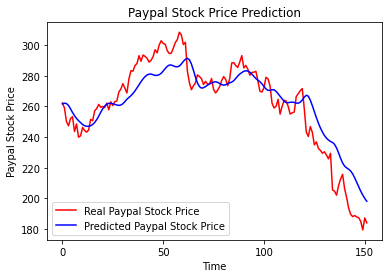

In [120]:
# Visualising the results
plt.plot(dataset_test.values, color = "red", label = "Real Paypal Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Paypal Stock Price")
plt.xticks(np.arange(0,len(predicted_stock_price),50))
plt.title('Paypal Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Paypal Stock Price')
plt.legend()
plt.show()

In [128]:
# evaluation 
mae = mean_absolute_error(dataset_test.values, predicted_stock_price)

In [129]:
mae

9.993547941509046

In [130]:
print(dataset_test.mean())

Close    261.493422
dtype: float64


In [126]:
prediction_frame = pd.DataFrame()
prediction_frame["truth"] = dataset_test
prediction_frame["preds"] = predicted_stock_price

In [162]:
dataset_test

,Close
Date,
2021-04-30,262.290009
2021-05-03,259.089996
2021-05-04,250.160004
2021-05-05,247.399994
2021-05-06,252.020004
...,...
2021-11-29,187.240005
2021-11-30,184.889999
2021-12-01,179.320007


In [127]:
prediction_frame

,truth,preds
Date,,
2021-04-30,262.290009,261.698578
2021-05-03,259.089996,262.136597
2021-05-04,250.160004,261.926880
2021-05-05,247.399994,260.696503
2021-05-06,252.020004,258.527161
...,...,...
2021-11-29,187.240005,207.403976
2021-11-30,184.889999,204.608307
2021-12-01,179.320007,202.152481


<AxesSubplot:xlabel='Date'>

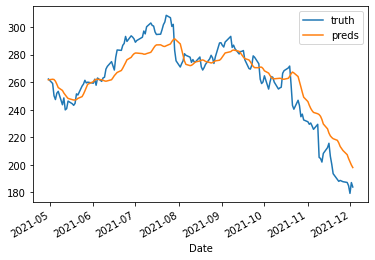

In [156]:
prediction_frame.plot()

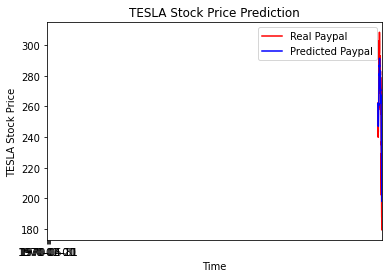

In [155]:
plt.plot(prediction_frame.index,prediction_frame.truth, color = "red", label = "Real Paypal")
plt.plot(prediction_frame.index,prediction_frame.preds, color = "blue", label = "Predicted Paypal")
plt.xticks(np.arange(0,len(predicted_stock_price),50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

# Looks not to bad 
Since the prediction above looks pretty good we will use the parameters as the default for our LSTM model class 

In [136]:
df_cols = pypl.columns 
try:
        df_cols[3] == "Close"
        print("hello")
except Exception as e: 
        print("no")
print("wow")


hello
wow


In [132]:
df_cols

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [141]:
df_cols = pypl.columns 
try:
    1 + 1 == 3
except Exception as e: 
        print(e)
print("wow")

wow


In [144]:
try:
    df_cols[2] == "Close"

False

In [147]:

if df_cols[2] == "Close":
    print("hello")
else break

SyntaxError: invalid syntax (584814027.py, line 3)

In [152]:

if df_cols[2] == "Close":
    print("wow")
else:
    sys.exit("aa! errors!")
    
print("hello")

SystemExit: aa! errors!

/Users/dennisweber/Desktop/projects/stock-market-pred-tool/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [170]:
training_set[i-60:i, 0]

array([168.        , 172.5       , 170.86999512, 168.3500061 ,
       174.22999573, 177.42999268, 177.21000671, 176.17999268,
       177.27999878, 181.57000732, 183.22999573, 178.3999939 ,
       171.50999451, 172.30000305, 172.05999756, 169.80999756,
       173.91999817, 178.82000732, 175.58000183, 178.41999817,
       173.86000061, 172.55999756, 177.97999573, 176.27000427,
       184.6000061 , 192.50999451, 196.07000732, 197.07000732,
       197.33000183, 202.91000366, 204.08999634, 198.63000488,
       193.32000732, 189.02999878, 191.32000732, 193.07000732,
       191.46000671, 196.28999329, 194.57000732, 192.44000244,
       198.17999268, 196.78999329, 198.88000488, 201.66999817,
       203.47999573, 204.33999634, 204.47999573, 204.13999939,
       208.92999268, 210.82000732, 204.99000549, 191.83999634,
       185.94999695, 194.6000061 , 190.08999634, 184.        ,
       186.96000671, 186.02000427, 180.91000366, 175.78999329])

In [171]:
training_set[i, 0]

176.07000732421875

In [159]:
type(X_train)

numpy.ndarray

In [172]:
prediction_frame

,truth,preds
Date,,
2021-04-30,262.290009,261.698578
2021-05-03,259.089996,262.136597
2021-05-04,250.160004,261.926880
2021-05-05,247.399994,260.696503
2021-05-06,252.020004,258.527161
...,...,...
2021-11-29,187.240005,207.403976
2021-11-30,184.889999,204.608307
2021-12-01,179.320007,202.152481


In [174]:
plot_df = prediction_frame.reset_index().melt("Date", var_name="name", value_name="Stock-Price")

In [175]:
plot_df

,Date,name,Stock-Price
0,2021-04-30,truth,262.290009
1,2021-05-03,truth,259.089996
2,2021-05-04,truth,250.160004
3,2021-05-05,truth,247.399994
4,2021-05-06,truth,252.020004
...,...,...,...
299,2021-11-29,preds,207.403976
300,2021-11-30,preds,204.608307
301,2021-12-01,preds,202.152481
302,2021-12-02,preds,199.902863


In [52]:
test_stock = yf.download(
        "AAPL", start='2020-12-05', end='2021-12-30', progress=False
    )

In [51]:
test_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-04,122.599998,122.860001,121.519997,122.250000,121.500977,78260400
2020-12-07,122.309998,124.570000,122.250000,123.750000,122.991783,86712000
2020-12-08,124.370003,124.980003,123.089996,124.379997,123.617920,82225500
2020-12-09,124.529999,125.949997,121.000000,121.779999,121.033852,115089200
2020-12-10,120.500000,123.870003,120.150002,123.239998,122.484909,81312200
...,...,...,...,...,...,...
2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200
2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300
2021-12-06,164.289993,167.880005,164.279999,165.320007,165.320007,107497000


In [23]:
test_stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-04,122.599998,122.860001,121.519997,122.250000,121.500977,78260400
2020-12-07,122.309998,124.570000,122.250000,123.750000,122.991783,86712000
2020-12-08,124.370003,124.980003,123.089996,124.379997,123.617920,82225500
2020-12-09,124.529999,125.949997,121.000000,121.779999,121.033844,115089200
2020-12-10,120.500000,123.870003,120.150002,123.239998,122.484901,81312200


In [31]:
for col in bbtest_stock.columns[1:]:
    print(col)

High
Low
Close
Adj Close
Volume


In [35]:
test = ['High', 'Low', 'Close', 'Adj Close', 'Volume']
test_day = ["Day"] + test

In [36]:
test_day

['Day', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [24]:
from model_creation.lstm import LstmModel

In [25]:
stocky = LstmModel(test_stock)

In [26]:
stocky.data_preparation()

(176, 1) (76, 1)


In [28]:
stocky.dataset_test

,Close
Date,
2021-08-18,146.360001
2021-08-19,146.699997
2021-08-20,148.190002
2021-08-23,149.710007
2021-08-24,149.619995
...,...
2021-11-29,160.240005
2021-11-30,165.300003
2021-12-01,164.770004


In [39]:
test = stocky.df

In [40]:
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-04,122.599998,122.860001,121.519997,122.250000,121.500977,78260400
2020-12-07,122.309998,124.570000,122.250000,123.750000,122.991783,86712000
2020-12-08,124.370003,124.980003,123.089996,124.379997,123.617920,82225500
2020-12-09,124.529999,125.949997,121.000000,121.779999,121.033844,115089200
2020-12-10,120.500000,123.870003,120.150002,123.239998,122.484901,81312200
...,...,...,...,...,...,...
2021-11-29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200
2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500


In [41]:
len(test)

252

In [42]:
test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200
2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500
2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200
2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300


In [43]:
test4 = test.iloc[-4:]

In [44]:
test4

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500
2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200
2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300


In [48]:
len(test)

252

In [47]:
test.iloc[:len(test) - 4]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-04,122.599998,122.860001,121.519997,122.250000,121.500977,78260400
2020-12-07,122.309998,124.570000,122.250000,123.750000,122.991783,86712000
2020-12-08,124.370003,124.980003,123.089996,124.379997,123.617920,82225500
2020-12-09,124.529999,125.949997,121.000000,121.779999,121.033844,115089200
2020-12-10,120.500000,123.870003,120.150002,123.239998,122.484901,81312200
...,...,...,...,...,...,...
2021-11-22,161.679993,165.699997,161.000000,161.020004,161.020004,117467900
2021-11-23,161.119995,161.800003,159.059998,161.410004,161.410004,96041900
2021-11-24,160.750000,162.139999,159.639999,161.940002,161.940002,69463600


In [49]:
test.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# New model

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np 
import plotly.graph_objects as go
import yfinance as yf 
import datetime
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import sys


In [2]:
test_stock = yf.download(
        "AAPL", start='2020-12-05', end='2021-12-30', progress=False
    )

In [3]:
from model_creation.lstm_copy import LstmModel

In [4]:
new = LstmModel(df=test_stock)

In [5]:
new.data_preparation()

In [6]:
new.model_training()

2021-12-08 21:53:54.200019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dennisweber/Desktop/projects/stock-market-pred-tool/model_creation/lstm_copy.py:132: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(self.train_generator, epochs=model_epochs, verbose=1)


Epoch 1/100
10/10 [==============================] - 6s 22ms/step - loss: 18119.3789
Epoch 2/100
10/10 [==============================] - 0s 17ms/step - loss: 17364.0000
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 16676.8125
Epoch 4/100
10/10 [==============================] - 0s 17ms/step - loss: 16214.0498
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 15900.8887
Epoch 6/100
10/10 [==============================] - 0s 18ms/step - loss: 15647.5771
Epoch 7/100
10/10 [==============================] - 0s 17ms/step - loss: 15461.0635
Epoch 8/100
10/10 [==============================] - 0s 17ms/step - loss: 15299.9844
Epoch 9/100
10/10 [==============================] - 0s 17ms/step - loss: 15151.3623
Epoch 10/100
10/10 [==============================] - 0s 17ms/step - loss: 14986.0742
Epoch 11/100
10/10 [==============================] - 0s 23ms/step - loss: 14837.7949
Epoch 12/100
10/10 [==============================] - 0s 18ms/s

In [7]:
new.model_predicting()

/Users/dennisweber/Desktop/projects/stock-market-pred-tool/model_creation/lstm_copy.py:136: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = self.model.predict_generator(self.test_generator)


AttributeError: 'LstmModel' object has no attribute 'rediction'

In [ ]:
new.close_test

array([[141.91000366],
       [142.83000183],
       [141.5       ],
       [142.6499939 ],
       [139.13999939],
       [141.11000061],
       [142.        ],
       [143.28999329],
       [142.8999939 ],
       [142.80999756],
       [141.50999451],
       [140.91000366],
       [143.75999451],
       [144.83999634],
       [146.55000305],
       [148.75999451],
       [149.25999451],
       [149.47999573],
       [148.69000244],
       [148.63999939],
       [149.32000732],
       [148.8500061 ],
       [152.57000732],
       [149.80000305],
       [148.96000671],
       [150.02000427],
       [151.49000549],
       [150.96000671],
       [151.27999878],
       [150.44000244],
       [150.80999756],
       [147.91999817],
       [147.86999512],
       [149.99000549],
       [150.        ],
       [151.        ],
       [153.49000549],
       [157.86999512],
       [160.55000305],
       [161.02000427],
       [161.41000366],
       [161.94000244],
       [156.80999756],
       [160

In [8]:
new.prediction

array([55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 ,
       55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 ,
       55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 ,
       55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.56376 , 55.563766,
       55.563766, 55.563766, 55.563763, 55.563766, 55.563766, 55.563766,
       55.563766, 55.563766, 55.563766, 55.563766, 55.563766, 55.563766],
      dtype=float32)

## new approach 

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import yfinance as yf 
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM 


Epoch 1/200
7/7 [==============================] - 4s 21ms/step - loss: 0.2703
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 0.1208
Epoch 3/200
7/7 [==============================] - 0s 17ms/step - loss: 0.1051
Epoch 4/200
7/7 [==============================] - 0s 16ms/step - loss: 0.0942
Epoch 5/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0863
Epoch 6/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0871
Epoch 7/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0745
Epoch 8/200
7/7 [==============================] - 0s 32ms/step - loss: 0.0869
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0812
Epoch 10/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0796
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0716
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0789
Epoch 13/200
7/7 [==============================]

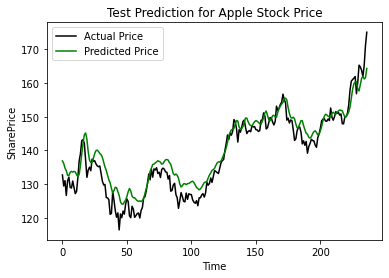

In [62]:


## start date
start = dt.datetime(2020,1,1)

## end date
end = dt.datetime(2021,1,1)

## load data 
apple = yf.download(
        "AAPL", start=start, end=end, progress=False
    )

## Prepare Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(apple["Close"].values.reshape(-1,1))

## window back 
backshift_days = 30 

## Xtarin and y train 
X_train = []
y_train = []

for x in range(backshift_days, len(scaled_data)):
    X_train.append(scaled_data[x-backshift_days:x, 0])
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Build Model 
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # Prediction of next closing value 

model.compile(optimizer="adam", loss="mean_absolute_error")

model.fit(X_train, y_train, epochs=200, batch_size=32)

## Test model Accuracy on Existing Data

# Load Test Data
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

apple_test = yf.download(
        "AAPL", start=test_start, end=test_end, progress=False
    )

## actual test prices 
actual_prices = apple_test["Close"].values 

total_dataset = pd.concat((apple["Close"], apple_test["Close"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(apple_test) - backshift_days:].values 
model_inputs = model_inputs.reshape(-1,1) 
model_inputs = scaler.transform(model_inputs)

## Make Predictions on Test Data 

X_test = []

for x in range(backshift_days, len(model_inputs)):
    X_test.append(model_inputs[x-backshift_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

### bring everything together 


# Plot the Test Predictions 
plt.plot(actual_prices, color="black", label="Actual Price")
plt.plot(predicted_prices, color="green", label="Predicted Price")
plt.title("Test Prediction for Apple Stock Price")
plt.xlabel("Time")
plt.ylabel("SharePrice")
plt.legend()
plt.show()





In [63]:
test_range = apple_test[["Close"]]
test_range["Prediction"] = predicted_prices
test_range

/var/folders/w6/3v68jtps1j56v4y_y6bx4z3c0000gn/T/ipykernel_39595/1271414980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_range["Prediction"] = predicted_prices


,Close,Prediction
Date,,
2020-12-31,132.690002,136.881943
2021-01-04,129.410004,136.141296
2021-01-05,131.009995,134.728119
2021-01-06,126.599998,133.954712
2021-01-07,130.919998,132.552231
...,...,...
2021-12-02,163.759995,161.409546
2021-12-03,161.839996,161.994537
2021-12-06,165.320007,161.207428


In [64]:
full = pd.concat([apple[["Close"]], test_range], axis=0)

<AxesSubplot:xlabel='Date'>

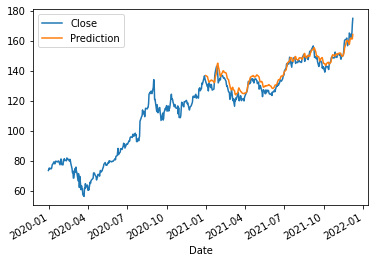

In [65]:
full.plot()

## Now Predicting The day we do not now yet 

In [66]:
real_data=[model_inputs[len(model_inputs)-backshift_days: len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[167.95729]]


### NOW make it pretty tomorrow

In [3]:
from model_creation.lstm_model import LstmModel